In [1]:

import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, JitTraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex
from pyro.util import ignore_jit_warnings

pyro.clear_param_store()
pyro.set_rng_seed(11)


In [2]:

import pandas as pd
import numpy as np

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
423,1,246000000,246500000,0.404142,47.146415,500000
424,1,246500000,247000000,0.428546,70.978030,500000
425,1,247000000,247500000,0.425162,58.722962,500000
426,1,247500000,248000000,0.400436,30.497224,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
gc = rtdata['gc'].values
num_cells = 170
num_loci = 100

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
gc = torch.tensor(gc[:num_loci])
cn = torch.tensor(cn[:num_loci, :])

# add a CNA for 30 cells in loci 30-60
cn[30:60, :30] = 1

### Play around with using true `cn` to create a reasonable prior for `cn_prob`

tensor([1.0000e+00, 3.1000e+01, 1.5902e+04, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00])
tensor([  1., 872.,  31.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.])


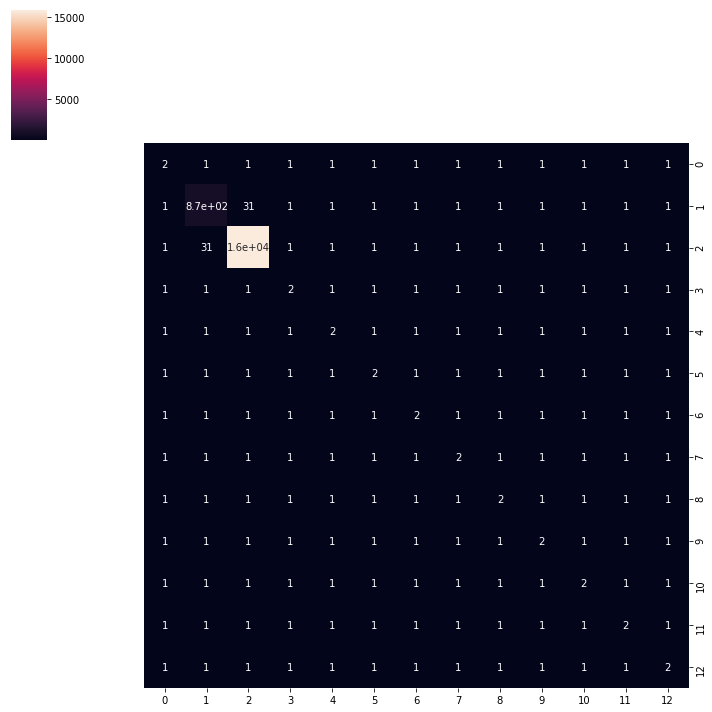

In [5]:
num_states = 13

# build the transition matrix using cn
trans_mat = torch.eye(num_states, num_states) + 1
for i in range(num_cells):
    for j in range(1, num_loci):
        cur_state = int(cn[j, i])
        prev_state = int(cn[j-1, i])
        trans_mat[prev_state, cur_state] += 1
#trans_mat = trans_mat / torch.sum(trans_mat, dim=1)
#trans_mat = trans_mat / torch.sum(trans_mat, dim=1)

# simple case where all diagonals are weighted highly
# off_diag_weight = 1e-6
# trans_mat = torch.eye(num_states, num_states) * (1-(num_states*off_diag_weight)) + off_diag_weight

#print(torch.sum(trans_mat, dim=1))
#print(torch.sum(trans_mat, dim=0))
print(trans_mat[2])
print(trans_mat[1])

sns.clustermap(trans_mat.numpy(), col_cluster=False, row_cluster=False, annot=True)
plt.show()

In [6]:
weight = 1e6
cn_prior = torch.ones(num_loci, num_cells, num_states)
for i in range(num_loci):
    for n in range(num_cells):
        state = int(cn[i, n].numpy())
        cn_prior[i, n, state] = weight
cn_prior[0,0]

tensor([1.0000e+00, 1.0000e+00, 1.0000e+06, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00])

### Define generative model for G1-phase cells

In [7]:
def make_gc_features(x, poly_degree=4):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in reversed(range(0, poly_degree+1))], 1)

softplus = torch.nn.Softplus()
relu = torch.nn.ReLU()

@config_enumerate
def model_g1(gc_profile, cn=None, num_cells=None, num_loci=None, data=None, u_guess=70., poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    betas = pyro.sample('expose_betas', dist.Normal(0., 1.).expand([poly_degree+1]).to_event(1))

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([u_guess]), torch.tensor([u_guess/10.])))

        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree)
            gc_rate = torch.exp(torch.sum(betas * gc_features, 1))
            biased_cn = cn * gc_rate.reshape(-1, 1)

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [8]:
pyro.clear_param_store()

conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
        'expose_betas': torch.tensor([0.1, 0.2, -1, 1, -0.25])*10.,
    })

model_trace_g1 = pyro.poutine.trace(conditioned_model_g1)

samples_g1 = model_trace_g1.get_trace(gc, cn)

betas_g1 = samples_g1.nodes['expose_betas']['value']
u_g1 = samples_g1.nodes['expose_u']['value']
nb_r_g1 = samples_g1.nodes['expose_nb_r']['value']
reads_g1 = samples_g1.nodes['reads']['value']

# reads_g1 = torch.zeros(cn.shape)
# for l in range(num_loci):
#     temp_reads = samples_g1.nodes['reads_{}'.format(l)]['value']
#     reads_g1[l] = temp_reads


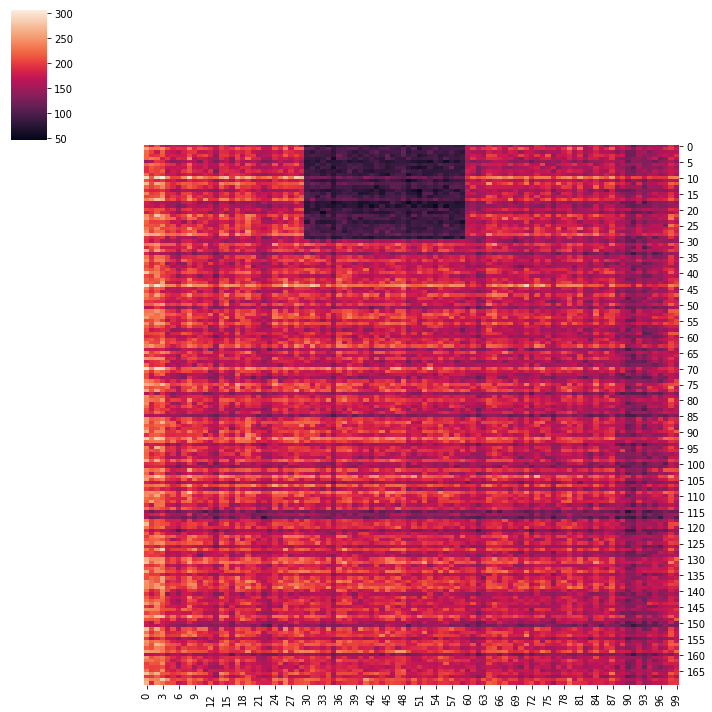

In [9]:
sns.clustermap(reads_g1.numpy().astype(float).T, col_cluster=False, row_cluster=False)

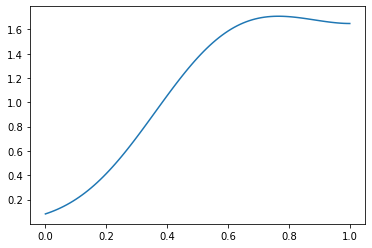

In [10]:
x = np.linspace(0, 1, 101)  # gc values

p1d = np.poly1d(betas_g1)
mean = np.exp(p1d(x))

plt.plot(x, mean)

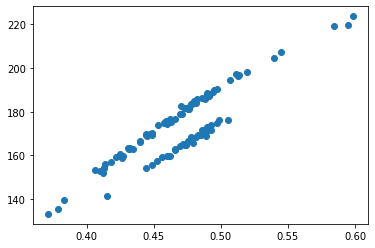

In [11]:
plt.scatter(x=gc, y=torch.mean(reads_g1, dim=1))
plt.show()

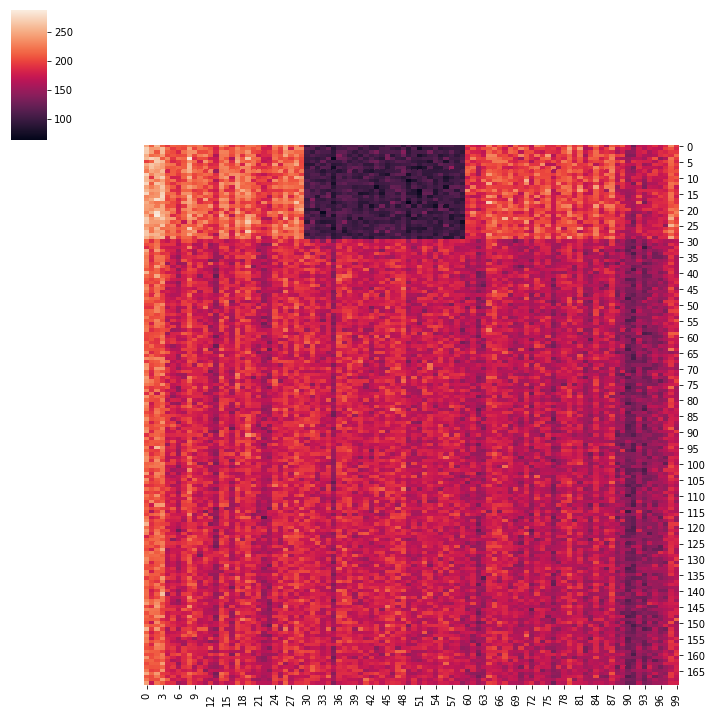

In [12]:
reads_per_cell_g1 = torch.mean(reads_g1) * num_loci
reads_norm_g1 = (reads_g1 / torch.sum(reads_g1, 0)) * reads_per_cell_g1
reads_norm_g1 = reads_norm_g1.type(torch.int64)

sns.clustermap(reads_norm_g1.numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

In [13]:
torch.sum(torch.isnan(reads_norm_g1))

tensor(0)

In [14]:
torch.sum(torch.where(reads_norm_g1 >= 0, 0, 1))

tensor(0)

### Infer parameters using G1-phase model

In [15]:
cn = cn.type(torch.float32)
reads_g1 = reads_g1.type(torch.float32)
reads_norm_g1 = reads_norm_g1.type(torch.float32)
gc = gc.type(torch.float32)

In [60]:
conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
#         'expose_betas': torch.tensor([0.1, 0.2, -1, 1, -0.25])*10.,
#         'expose_nb_r': 10000.0,
        'expose_u': u_g1
    })

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)

guide_g1 = AutoDelta(
    poutine.block(conditioned_model_g1, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model_g1, guide_g1, optim, loss=elbo)


In [61]:
u_guess_g1 = torch.mean(reads_norm_g1) / torch.mean(cn)

In [62]:
# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model_g1, guide_g1, gc, cn=cn, data=reads_g1, u_guess=u_guess_g1)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py:356: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  "TraceEnum_ELBO found no sample sites configured for enumeration. "


168412.0625

In [63]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc, cn=cn, data=reads_g1, u_guess=u_guess_g1)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

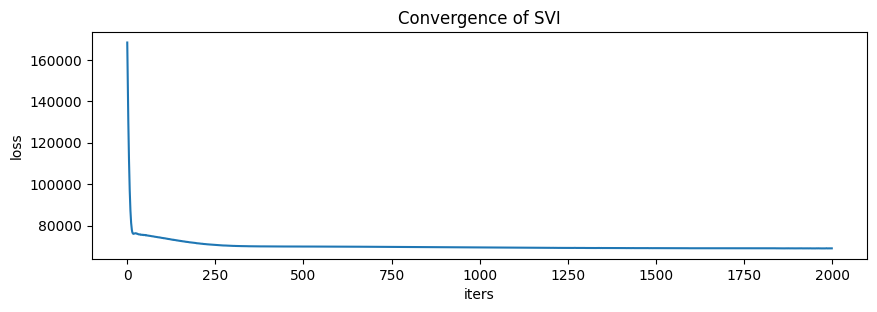

In [64]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [65]:
# replay model
guide_trace_g1 = poutine.trace(guide_g1).get_trace(gc, cn=cn, data=reads_g1, u_guess=u_guess_g1)
trained_model_g1 = poutine.replay(model_g1, trace=guide_trace_g1)

# infer discrete sites and get model trace
inferred_model_g1 = infer_discrete(
    trained_model_g1, temperature=0,
    first_available_dim=-3)
trace_g1 = poutine.trace(inferred_model_g1).get_trace(gc, cn=cn, data=reads_g1, u_guess=u_guess_g1)

# extract fitted parameters
nb_r_fit = trace_g1.nodes['expose_nb_r']['value']
betas_fit = trace_g1.nodes['expose_betas']['value']
u_fit = trace_g1.nodes['expose_u']['value']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/discrete.py:99: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  "infer_discrete found no sample sites configured for enumeration. "


In [66]:
betas_fit

tensor([-3.7759, -0.1801,  2.1382,  2.0131, -0.9720],
       grad_fn=<ExpandBackward0>)

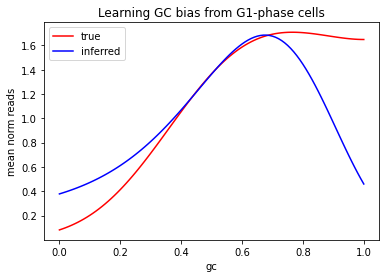

In [67]:
x = np.linspace(0, 1, 101)  # gc values

# plt.scatter(x=gc, y=torch.mean(reads_g1, dim=1))

# true gc betas
p1d = np.poly1d(betas_g1)
mean = np.exp(p1d(x))
plt.plot(x, mean, 'r', label='true')

# inferred gc betas
p1d_fit = np.poly1d(betas_fit.detach().numpy())
mean_fit = np.exp(p1d_fit(x))
plt.plot(x, mean_fit, 'b', label='inferred')

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
plt.legend()
plt.show()

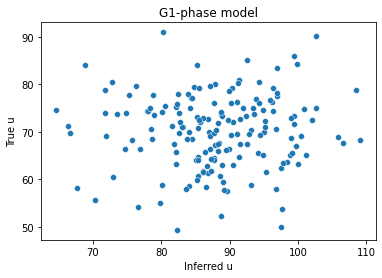

In [68]:
sns.scatterplot(x=u_fit.detach().numpy(), y=u_g1.detach().numpy())
plt.xlabel('Inferred u')
plt.ylabel('True u')
plt.title('G1-phase model')
plt.show()

In [49]:
nb_r_fit

tensor([3104.9070], grad_fn=<AddBackward0>)

In [50]:
nb_r_g1

tensor([10000.0010], grad_fn=<AddBackward0>)

In [ ]:
plt.scatter(x=gc, y=torch.mean(reads_g1, dim=1))
plt.show()

### Define generative model for S-phase cells

In [22]:

@config_enumerate
def model_S(gc_profile, betas=None, cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, trans_mat=None, cn_prior=None, u_guess=70., nb_r_guess=10000.):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn0 is not None:
            num_loci, num_cells = cn0.shape
        assert num_cells is not None
        assert num_loci is not None

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([nb_r_guess]), constraint=constraints.positive)
    
    # transition probabilities for HMM
    if trans_mat is None:
        trans_mat = pyro.sample('expose_trans_prob',
                                dist.Dirichlet(0.99 * torch.eye(13) + 0.01).to_event(1))
    
    # gc bias params
    if betas is None:
        poly_degree = 4
        betas = pyro.sample('expose_betas', dist.Normal(0., 1.).expand([poly_degree+1]).to_event(1))
    else:
        poly_degree = betas.shape[0]-1

    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        time = pyro.sample('expose_time', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))
        
        # starting states for markov chain
        if cn0 is None:
            cn = 2

        for l in pyro.markov(range(num_loci)):

            # sample copy number states using HMM structure
            if cn0 is None:
                temp_cn_prob = trans_mat[cn]
                if cn_prior is not None:
                    temp_cn_prob = temp_cn_prob * cn_prior[l]
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l]
                
            # per cell per bin late or early 
            time_diff = time.reshape(-1, num_cells) - rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))
            
            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            # copy number accounting for gc bias
            gc_features = make_gc_features(torch.tensor([gc_profile[l]]), poly_degree=poly_degree)
            gc_rate = torch.exp(torch.sum(betas * gc_features, 1))
            biased_cn = rep_cn * gc_rate.reshape(-1, 1)

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if data is not None:
                obs = data[l]
            else:
                obs = None
            
            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

# trace = poutine.trace(model_S).get_trace(cn, rt, num_cells=num_cells)
# trace.compute_log_prob()
# print(trace.format_shapes())
# pyro.render_model(model_S, model_args=(cn, rt, num_cells), 
#                   render_distributions=True, render_params=True)

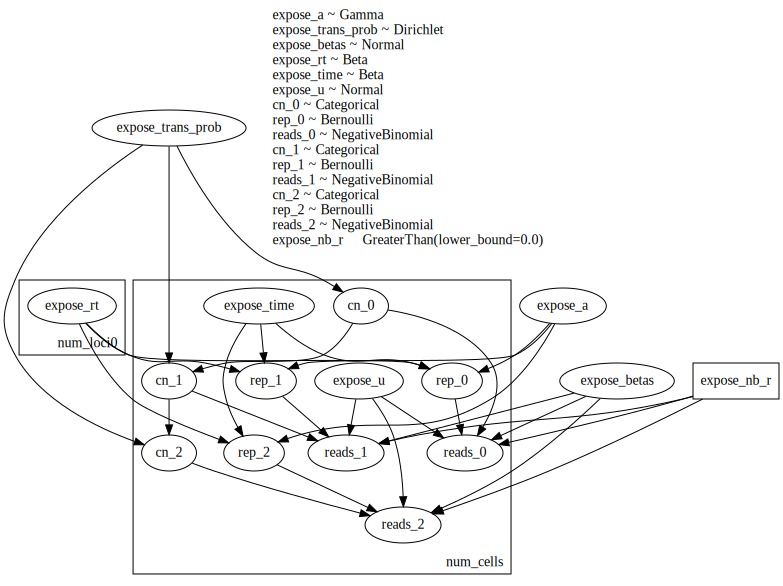

In [23]:
# trace = poutine.trace(model_S).get_trace(None, num_cells=num_cells, num_loci=num_loci)
# trace.compute_log_prob()
# print(trace.format_shapes())
pyro.render_model(model_S, model_args=(gc[:3], None, None, None, num_cells, 3), 
                  render_distributions=True, render_params=True)

### Simulate and visualize data

In [24]:

# Simulate conditioned on a, get reads, replication timing etc

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S,
    data={
        'expose_a': torch.tensor([10.]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(gc, betas_g1, cn, rt, num_cells=num_cells)

time = samples.nodes['expose_time']['value']
a = samples.nodes['expose_a']['value']
u = samples.nodes['expose_u']['value']
nb_r = samples.nodes['expose_nb_r']['value']

time_diff = time.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-a * time_diff))

rep = torch.zeros(cn.shape)
rep_cn = torch.zeros(cn.shape)
reads = torch.zeros(cn.shape)
for l in range(num_loci):
    temp_rep = samples.nodes['rep_{}'.format(l)]['value']
    temp_rep_cn = cn[l] * (1. + temp_rep)
    temp_reads = samples.nodes['reads_{}'.format(l)]['value']
    rep[l] = temp_rep
    rep_cn[l] = temp_rep_cn
    reads[l] = temp_reads


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


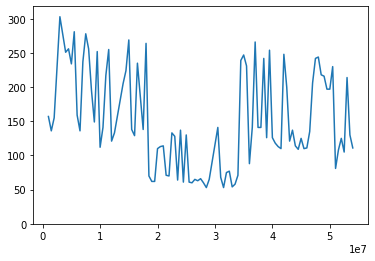

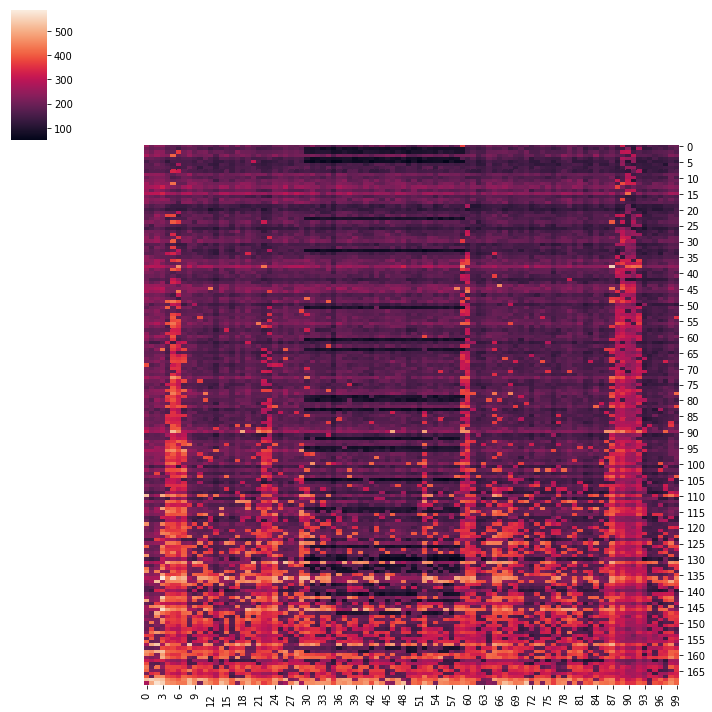

In [25]:
# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)

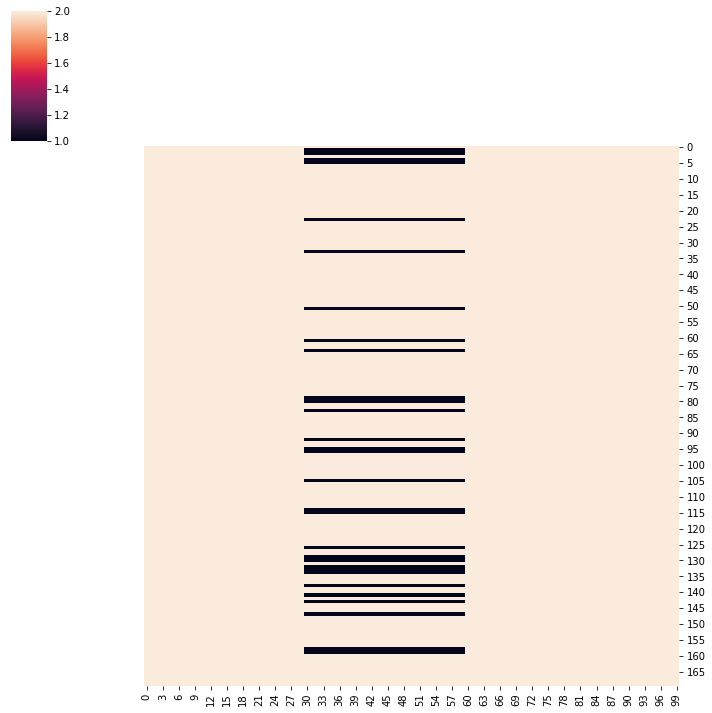

In [26]:
# visualize the true copy number heatmap
sns.clustermap(cn.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)
plt.show()

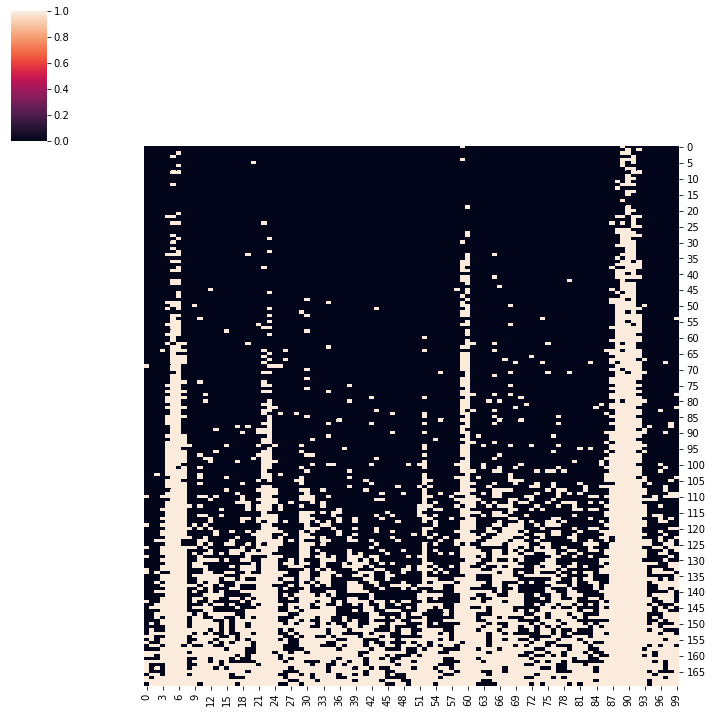

In [27]:
# visualize the true replication heatmap
sns.clustermap(rep.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


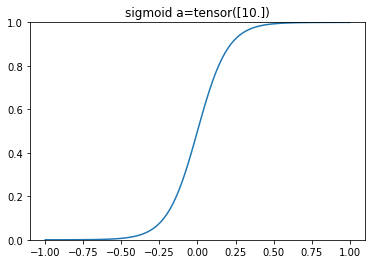

In [28]:
def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(samples.nodes['expose_a']['value'].detach())


### Normalize each cell to the same total number of reads

In [29]:
reads_per_cell = torch.mean(reads) * num_loci
reads_norm = (reads / torch.sum(reads, 0)) * reads_per_cell
reads_norm = reads_norm.type(torch.int64)

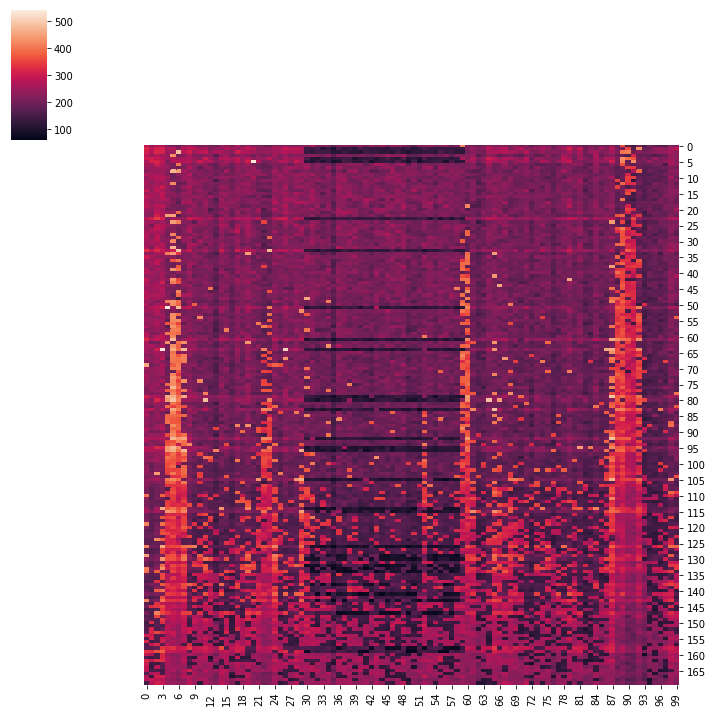

In [30]:
sns.clustermap(reads_norm.numpy().astype(float).T[np.argsort(time), :], col_cluster=False, row_cluster=False)
plt.show()

### Infer all relevant params just taking `reads_norm` as input

In [31]:
cn = cn.type(torch.float32)
reads = reads.type(torch.float32)
reads_norm = reads_norm.type(torch.float32)
trans_mat = trans_mat.type(torch.float32)
cn_prior = cn_prior.type(torch.float32)
rt = rt.type(torch.float32)
gc = gc.type(torch.float32)

In [32]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = JitTraceEnum_ELBO(max_plate_nesting=1)


In [33]:
condition_dict = {}
for l in range(num_loci):
    condition_dict['rep_{}'.format(l)] = torch.zeros(num_cells)
condition_dict

{'rep_0': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 'rep_1': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0

In [34]:

conditioned_model = poutine.condition(
    model_S,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
    })

# conditioned_model_G1 = poutine.condition(
#     model_S,
#     data=condition_dict
# )

guide = AutoDelta(
    poutine.block(conditioned_model, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [35]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, gc, betas=betas_g1, data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)


141218.03125

In [36]:

# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc, betas=betas_g1, data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/poutine/subsample_messenger.py:171: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(shape) >= -dim and shape[dim] != 1:
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/poutine/subsample_messenger.py:171: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(shape) >= -dim and shape[dim] != 1:
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/po

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:75: TracerWarning: torch.tensor results are registered as constants i


...............................................................................
...............................................................................
...............................................................................
..........................................................................

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/special.py(32): safe_log
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/einsum/torch_log.py(51): einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/einsum/torch_sample.py(68): einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(353): _einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/sharing.py(101): _memoize
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/sharing.py(168): cached_einsum
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(591): _core_contract
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(698): _contract
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/opt_einsum/contract.py(763): __call__
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/einsum/__init__.py(46): contract
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/rings.py(199): sumproduct
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/contract.py(125): _contract_component
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/contract.py(200): contract_tensor_tree
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(199): _compute_dice_elbo
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(556): differentiable_loss
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/poutine/messenger.py(12): _context_wrap
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/jit.py(99): compiled
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/torch/jit/_trace.py(793): trace
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/jit.py(108): __call__
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(561): differentiable_loss
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(564): loss_and_grads
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/svi.py(145): step
<ipython-input-36-325a1be62ea1>(7): <module>
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3326): run_code
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249): run_ast_nodes
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3058): run_cell_async
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2881): _run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2855): run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(539): run_cell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py(302): do_execute
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(538): execute_request
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(261): dispatch_shell
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(358): process_one
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(775): run
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(741): __init__
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(250): wrapper
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(374): dispatch_queue
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(775): run
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(814): inner
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(741): _run_callback
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(688): <lambda>
/home/weinera2/miniconda3/lib/python3.7/asyncio/events.py(88): _run
/home/weinera2/miniconda3/lib/python3.7/asyncio/base_events.py(1771): _run_once
/home/weinera2/miniconda3/lib/python3.7/asyncio/base_events.py(534): run_forever
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/platform/asyncio.py(199): start
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py(612): start
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/traitlets/config/application.py(664): launch_instance
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py(16): <module>
/home/weinera2/miniconda3/lib/python3.7/runpy.py(85): _run_code
/home/weinera2/miniconda3/lib/python3.7/runpy.py(193): _run_module_as_main
RuntimeError: KeyboardInterrupt: 

At:
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/special.py(16): forward
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/ops/jit.py(120): __call__
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(561): differentiable_loss
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py(564): loss_and_grads
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/svi.py(145): step
  <ipython-input-36-325a1be62ea1>(7): <module>
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3326): run_code
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3249): run_ast_nodes
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3058): run_cell_async
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2881): _run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2855): run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/zmqshell.py(539): run_cell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/ipkernel.py(302): do_execute
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(538): execute_request
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(261): dispatch_shell
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(234): wrapper
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(358): process_one
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(775): run
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(741): __init__
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(250): wrapper
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelbase.py(374): dispatch_queue
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(775): run
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/gen.py(814): inner
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(741): _run_callback
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/ioloop.py(688): <lambda>
  /home/weinera2/miniconda3/lib/python3.7/asyncio/events.py(88): _run
  /home/weinera2/miniconda3/lib/python3.7/asyncio/base_events.py(1771): _run_once
  /home/weinera2/miniconda3/lib/python3.7/asyncio/base_events.py(534): run_forever
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/tornado/platform/asyncio.py(199): start
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel/kernelapp.py(612): start
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/traitlets/config/application.py(664): launch_instance
  /juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py(16): <module>
  /home/weinera2/miniconda3/lib/python3.7/runpy.py(85): _run_code
  /home/weinera2/miniconda3/lib/python3.7/runpy.py(193): _run_module_as_main



In [ ]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


### Visualize model output results for `rep` and `cn`

In [ ]:

# Plot replicated state

guide_trace = poutine.trace(guide).get_trace(gc, betas=betas_g1, data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)
trained_model = poutine.replay(conditioned_model, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-3)
trace = poutine.trace(inferred_model).get_trace(gc, betas=betas_g1, data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)

model_rep = torch.zeros(cn.shape)
model_cn = torch.zeros(cn.shape)
model_rep_cn = torch.zeros(cn.shape)
model_reads = torch.zeros(cn.shape)
for l in range(num_loci):
    temp_rep = trace.nodes['rep_{}'.format(l)]['value']
    temp_cn = trace.nodes['cn_{}'.format(l)]['value']
    temp_rep_cn = temp_cn * (1. + temp_rep)
    temp_reads = trace.nodes['reads_{}'.format(l)]['value']
    model_rep[l] = temp_rep
    model_cn[l] = temp_cn
    model_rep_cn[l] = temp_rep_cn
    model_reads[l] = temp_reads

sns.clustermap(model_rep.numpy().astype(float).T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)

In [ ]:
sns.clustermap(model_cn.numpy().astype(float).T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)
plt.show()

In [ ]:
map_estimates = guide(data=reads_norm, trans_mat=trans_mat)

In [ ]:
map_estimates.keys()

In [ ]:
map_estimates['expose_time'].shape

In [ ]:
map_estimates['expose_rt'].shape

In [ ]:
# compute p_rep for each bin using t, rt, and a
time_diff = trace.nodes['expose_time']['value'].reshape(-1, num_cells) - trace.nodes['expose_rt']['value'].reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-trace.nodes['expose_a']['value'] * time_diff))
p_rep = p_rep.detach().numpy().astype(float)
p_rep.shape

In [ ]:
rep_maxprob = np.zeros(p_rep.shape)
for i in range(rep_maxprob.shape[0]):
    for j in range(rep_maxprob.shape[1]):
        rep_maxprob[i, j] = 1 if p_rep[i, j] > 0.5 else 0

In [ ]:
sns.clustermap(p_rep.T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)
plt.show()

In [ ]:
sns.clustermap(rep_maxprob.T[np.argsort(time), :],
               col_cluster=False, row_cluster=False)
plt.show()

In [ ]:

sns.scatterplot(
    x=time,
    y=map_estimates['expose_time'].detach().numpy(),
)
plt.xlabel('True time')
plt.ylabel('Inferred time')
plt.show()

In [ ]:
sns.scatterplot(
    x=rt,
    y=map_estimates['expose_rt'].detach().numpy(),
)
plt.xlabel('True bulk rt')
plt.ylabel('Inferred bulk rt')
plt.show()

In [ ]:
model1_accuracy = 1.0 - (np.sum(abs(rep.numpy() - model_rep.numpy())) / (rep.shape[0] * rep.shape[1]))
model1_accuracy

In [ ]:
model1_maxprob_accuracy = 1.0 - (np.sum(abs(rep.numpy() - rep_maxprob)) / (rep.shape[0] * rep.shape[1]))
model1_maxprob_accuracy

### Now try to infer with a model that treats all loci independently (agnostic to a bulk `rt` profile)

In [ ]:
u_guess = torch.mean(reads_norm) / (1.5 * torch.mean(cn))
u_guess

### Wrangle the true and inferred values into a dataframe

In [ ]:
cn_s_out = []
for i in range(num_cells):
    temp_cn = rtdata.iloc[:num_loci]
    temp_cn['cell_id'] = 'cell_{}'.format(i)
    temp_cn['state'] = cn[:,i]
    temp_cn['reads'] = reads[:,i]
    temp_cn['reads_norm'] = reads_norm[:,i]
    temp_cn['true_rep'] = rep[:,i]
    temp_cn['true_u'] = u[i].numpy()
    temp_cn['true_time'] = time[i].numpy()
    temp_cn['true_nb_r'] = nb_r.detach().numpy()[0]
    temp_cn['true_a'] = a.numpy()[0]
    
    # results from model_S
    temp_cn['model1_rep'] = model_rep.numpy()[:,i]
    temp_cn['model1_time'] = trace.nodes["expose_time"]["value"][i].detach().numpy()
    temp_cn['model1_u'] = trace.nodes["expose_u"]["value"][i].detach().numpy()
    temp_cn['model1_nb_r'] = trace.nodes["expose_nb_r"]["value"][0].detach().numpy()
    temp_cn['model1_a'] = trace.nodes["expose_a"]["value"][0].detach().numpy()
    
    cn_s_out.append(temp_cn)
cn_s_out = pd.concat(cn_s_out, ignore_index=True)

In [ ]:
cn_s_out.head()

In [ ]:
for cell_id, chunk in cn_s_out.groupby('cell_id'):
    # add fraction of replicated bins per cell
    temp_rep0 = chunk.true_rep.values
    cn_s_out.loc[chunk.index, 'true_frac_rt'] = sum(temp_rep0) / temp_rep0.shape[0]
    temp_rep1 = chunk.model1_rep.values
    cn_s_out.loc[chunk.index, 'model1_frac_rt'] = sum(temp_rep1) / temp_rep1.shape[0]
    
    # add per-cell replication state acccuracy
    accuracy1 = 1.0 - (sum(abs(chunk['true_rep'] - chunk['model1_rep'])) / chunk.shape[0])
    cn_s_out.loc[chunk.index, 'model1_rep_acc'] = accuracy1
    
cn_s_out.head()

In [ ]:
cell_metrics = cn_s_out[['cell_id', 'true_a', 'true_nb_r', 'true_time', 'true_u', 'true_frac_rt', 'model1_rep_acc',
                         'model1_nb_r', 'model1_a', 'model1_time', 'model1_u', 'model1_frac_rt']].drop_duplicates()
cell_metrics.shape

In [ ]:
cell_metrics.head()

In [ ]:
loci_metrics = rtdata.iloc[:num_loci]
loci_metrics['true_bulk_rt'] = np.mean(rep.numpy(), axis=1)
loci_metrics['model1_bulk_rt'] = np.mean(model_rep.numpy(), axis=1)
loci_metrics.head()

### Evaluate performance of model1 (same as generative)

In [ ]:
sns.scatterplot(data=cell_metrics, x='true_time', y='model1_time', hue='model1_rep_acc', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=cell_metrics, x='true_u', y='model1_u', hue='model1_rep_acc', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=cell_metrics, x='true_frac_rt', y='model1_frac_rt', hue='model1_rep_acc', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=loci_metrics, x='true_bulk_rt', y='model1_bulk_rt', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=loci_metrics, x='norm_mcf7rt', y='model1_bulk_rt', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=cell_metrics, x='model1_time', y='model1_u', hue='model1_rep_acc', alpha=0.3)
plt.show()